# A/B Testing: Technical Appendices

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline
from scipy import stats


In [83]:
#import data
visitor_data=pd.read_csv('Spring 2018 - Product Case Data.csv')
visitor_data.drop(['Unnamed: 8','Unnamed: 9'],axis=1,inplace=True)
visitor_data


,Date,Channel,User Type,Land,Bounce,Purchase,Visitors_Control,Visitors_Variant
0,2014-10-10,Affiliate,Returning User,0,0,0,1211,1175
1,2014-10-10,Affiliate,Returning User,1,0,0,4076,4810
2,2014-10-10,Affiliate,Returning User,1,1,0,2766,3386
3,2014-10-10,Affiliate,Returning User,0,0,1,196,159
4,2014-10-10,Affiliate,Returning User,1,0,1,358,332
5,2014-10-10,Affiliate,New User,0,0,0,1589,1574
6,2014-10-10,Affiliate,New User,1,0,0,7165,6501
7,2014-10-10,Affiliate,New User,1,1,0,4709,4211
8,2014-10-10,Affiliate,New User,0,0,1,132,150
9,2014-10-10,Affiliate,New User,1,0,1,640,694


In [84]:
#Build a function calculating aggregate relative differencs
def rel_diff(final,initial):
    change=(final-initial)/initial*100
    change=round(change,3)
    return change
    


In [85]:
bytype=visitor_data.groupby('User Type').sum().drop(['Land','Bounce','Purchase'], axis=1)
bytype.rename(columns={'Visitors_Control':'Visitors (Control)','Visitors_Variant':'Visitors (Variant)'}, inplace=True)
bytype

,Visitors (Control),Visitors (Variant)
User Type,,
New User,1778012,1826430
Returning User,1218325,1219423


In [86]:
bychannel=visitor_data.groupby('Channel').sum().drop(['Land','Bounce','Purchase'], axis=1)
bychannel.rename(columns={'Visitors_Control':'Visitors (Control)','Visitors_Variant':'Visitors (Variant)'}, inplace=True)
bychannel

,Visitors (Control),Visitors (Variant)
Channel,,
Affiliate,502864,505955
Direct,1126827,1139063
Email,204567,208926
Paid Search,303561,311830
SEO,708959,730528
Social Media,149559,149551


## Appendix A: Conversion Rate


In [87]:
#Build a function that calculates the conversion rate for the control and variant over the test period

def calc_conrate(sample_type):
    #Calculate the number of people in the sample group who made a purchase
    no_vispurchase=visitor_data[visitor_data['Purchase']==1 ][sample_type].sum()
    #Calculate total visitors. Since all returning users were new users at some point,count all new users 
    #to get all "unique" visitors to the website and avoid double counting. Since we don't have a unique identifier 
    #for each user, we have to ignore the case where a user first visited the website before the test period
    no_visitors=visitor_data.groupby("User Type").sum().loc["New User",sample_type]
    con_rate=no_vispurchase/no_visitors
    return con_rate

control_conrate=calc_conrate('Visitors_Control')
variant_conrate=calc_conrate('Visitors_Variant')

#Note that a visitor may be making more than one purchase, however, we can't account for this in the conversion rate
#because the data doesn't provide unique IDs for visitors. As a result, we may have overestimated the con rate. 

conrate={"Control Conversion Rate":control_conrate,"Variant Conversion Rate":variant_conrate}
conrate

{'Control Conversion Rate': 0.093668096728256059,
 'Variant Conversion Rate': 0.088470951528391448}

In [88]:
#Calculate the aggregate relative difference in conversion rates for the variant and control

aggcon_diff=  rel_diff(variant_conrate,control_conrate)
print('Aggregate Relative Difference in Conversion Rates : {}% '.format(aggcon_diff))

Aggregate Relative Difference in Conversion Rates : -5.548% 


In [89]:
#Build a function calculating conversion rates for each day
def calc_dailycon(sample_type):
    time_series=visitor_data.groupby('Date')\
    .apply(lambda x: x[x['Purchase']==1][sample_type].sum()\
    / x[x['User Type']=='New User'][sample_type].sum())
    return time_series

varcon_timeser=calc_dailycon('Visitors_Variant')
contcon_timeser=calc_dailycon('Visitors_Control')
varcon_timeser.index=pd.to_datetime(varcon_timeser.index)
contcon_timeser.index=pd.to_datetime(contcon_timeser.index)


    
    

In [90]:
#Perform t-test to determine if the difference in converion rates between the variant and control is statistically
#significant
test_con=stats.ttest_rel(contcon_timeser,varcon_timeser)
test_con
#The p-value is quite big - way over the .05 standard. We reject the null hypothesis that the  mean
#conversion rates across the control and variant are not significantly different. In other words, the variant
#performs worse than the control because of the proposed changes to the homepage and not due to chance(or randomness) 



Ttest_relResult(statistic=5.2818944809164448, pvalue=3.6076664274633595e-05)

In [91]:
#Summarize the data on conversion rate
convdata={'Control Conversion Rate':[control_conrate],
                   'Variant Conversion Rate': [variant_conrate],
                   'Agg. Relative Difference (%)': [rel_diff(variant_conrate,control_conrate)], 
                   'Statistical Significance (95% level)':[(test_con[1]<0.05)]}

convdata=pd.DataFrame(convdata) 
convdata=convdata[['Control Conversion Rate','Variant Conversion Rate','Agg. Relative Difference (%)','Statistical Significance (95% level)']]
convdata.round(3)



,Control Conversion Rate,Variant Conversion Rate,Agg. Relative Difference (%),Statistical Significance (95% level)
0,0.094,0.088,-5.548,True


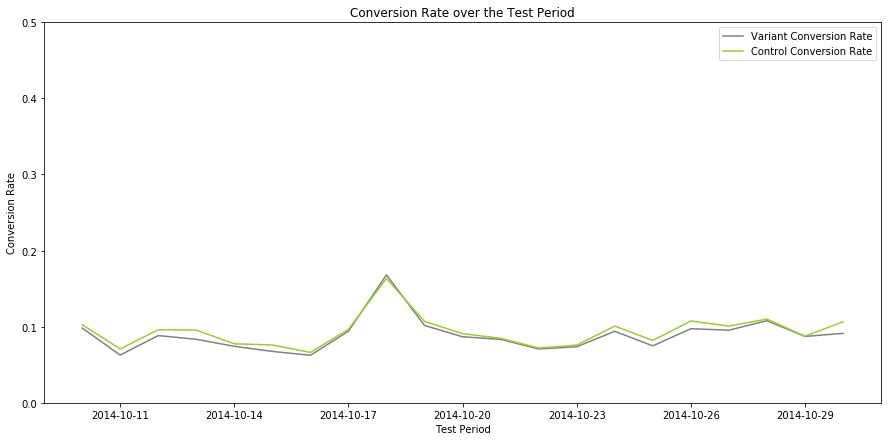

In [145]:
#Plot the control and variant conversion rate over the test period.
plt.subplots(figsize=(15, 7))
plt.plot(varcon_timeser.index, varcon_timeser.values,'gray', label='Variant Conversion Rate')
plt.plot(contcon_timeser.index, contcon_timeser.values,'yellowgreen', label='Control Conversion Rate')
plt.ylim(0,0.5)
plt.title('Conversion Rate over the Test Period')
plt.ylabel('Conversion Rate')
plt.xlabel('Test Period')
plt.legend()

In [156]:
#Calculate Conversion Rate by time of week
bytime=visitor_data
bytime['Date']=pd.to_datetime(bytime['Date'])
bytime['Day of Week']=bytime['Date'].dt.strftime('%a')

#bytime[(bytime['Day of Week']=='Thu')|(bytime['Day of Week']=='S')|(bytime['Day of Week']=='Sun')]
#bytime[bytime['Purchase']==1]['Visitors_Control'].sum()

def con_weektime(sample_type,weektime):
    if weektime=='weekday':
        betime=bytime[(bytime['Day of Week']=='Mon')|(bytime['Day of Week']=='Tue')|(bytime['Day of Week']=='Wed')|(bytime['Day of Week']=='Thu')]
    elif weektime=='weekend':
         betime=bytime[(bytime['Day of Week']=='Fri')|(bytime['Day of Week']=='Sat')|(bytime['Day of Week']=='Sun')]
    else:
         print("Oops!  That was not a valid entry.  Try again...")
    
    no_vispurchase=betime[betime['Purchase']==1][sample_type].sum() 
    no_visitors= betime[betime['User Type']=='New User'][sample_type].sum()
    we_cr=no_vispurchase/no_visitors
    return we_cr

cont_wd=con_weektime('Visitors_Control','weekday')
var_wd=con_weektime('Visitors_Variant','weekday')
cont_we=con_weektime('Visitors_Control','weekend')
var_we=con_weektime('Visitors_Variant','weekend')

condata_bytime={'Control Conversion Rate':[cont_wd, cont_we],
                'Variant Conversion Rate':[var_wd, var_we],
                'Agg. Relative Difference (%)': [rel_diff(var_wd,cont_wd),rel_diff(var_we,cont_we)]} 

convdata_bytime= pd.DataFrame(condata_bytime, index=['Week Days', 'Weekend & Friday']) 
convdata_bytime=convdata_bytime[['Control Conversion Rate','Variant Conversion Rate','Agg. Relative Difference (%)']]
convdata_bytime.round(3)




,Control Conversion Rate,Variant Conversion Rate,Agg. Relative Difference (%)
Week Days,0.086,0.082,-5.561
Weekend & Friday,0.103,0.098,-5.572


In [154]:
def bon_weektime(sample_type,weektime):
    if weektime=='weekday':
        betime=bytime[(bytime['Day of Week']=='Mon')|(bytime['Day of Week']=='Tue')|(bytime['Day of Week']=='Wed')|(bytime['Day of Week']=='Thu')]
    elif weektime=='weekend':
         betime=bytime[(bytime['Day of Week']=='Fri')|(bytime['Day of Week']=='Sat')|(bytime['Day of Week']=='Sun')]
    else:
         print("Oops!  That was not a valid entry.  Try again...")
    
    no_visbounce=betime[betime['Bounce']==1][sample_type].sum() 
    no_visland= betime[betime['Land']==1][sample_type].sum()
    we_br=no_visbounce/no_visland
    return we_br

cont_wd=bon_weektime('Visitors_Control','weekday')
var_wd=bon_weektime('Visitors_Variant','weekday')
cont_we=bon_weektime('Visitors_Control','weekend')
var_we=bon_weektime('Visitors_Variant','weekend')

bondata_bytime={'Control Bounce Rate':[cont_wd, cont_we],
                'Variant Bounce Rate':[var_wd, var_we],
                'Agg. Relative Difference (%)': [rel_diff(var_wd,cont_wd),rel_diff(var_we,cont_we)]} 

bonvdata_bytime= pd.DataFrame(bondata_bytime, index=['Week Days', 'Weekend & Friday']) 
bonvdata_bytime=bonvdata_bytime[['Control Bounce Rate','Variant Bounce Rate','Agg. Relative Difference (%)']]
bonvdata_bytime.round(3)



,Control Bounce Rate,Variant Bounce Rate,Agg. Relative Difference (%)
Week Days,0.411,0.427,4.004
Weekend & Friday,0.378,0.393,4.027


## Appendix B:  Bounce Rate

In [97]:
#Build a function that calculates the bounce rate for the control and variant

def calc_bonrate(sample_type):
    #Calculate the number of people in the sample group who made a purchase
    no_bounce=visitor_data[(visitor_data['Bounce']==1)][sample_type].sum()
    #In calculating total number of visitors that land, we consider both new and repeat visitors
    no_landvis=visitor_data.groupby("Land").sum().loc[1,sample_type]
    bon_rate=no_bounce/no_landvis
    return bon_rate

control_bonrate=calc_bonrate('Visitors_Control')
variant_bonrate=calc_bonrate('Visitors_Variant')

bonrate={"Control Bounce Rate":control_bonrate,"Variant Bounce Rate":variant_bonrate}
bonrate

{'Control Bounce Rate': 0.39664129172226437,
 'Variant Bounce Rate': 0.41265502144877347}

In [98]:
#Calculate the aggregate relevant difference in bounce rates

aggbon_diff= rel_diff(variant_bonrate,control_bonrate)
print('Aggregate Relative Difference in Bounce Rates: {}% '.format(aggbon_diff))

Aggregate Relative Difference in Bounce Rates: 4.037% 


In [99]:
#Build a function calculating bounce rates for each day
def calc_dailybon(sample_type):
    time_series=visitor_data.groupby('Date')\
    .apply(lambda x: x[x['Bounce']==1][sample_type].sum()\
    / x[x['Land']==1][sample_type].sum())
    return time_series

variant_timeser=calc_dailybon('Visitors_Variant')
control_timeser=calc_dailybon('Visitors_Control')
variant_timeser.index=pd.to_datetime(variant_timeser.index)
control_timeser.index=pd.to_datetime(control_timeser.index)

In [100]:
#Perform t-test to determine if the difference in bounce rates between the variant and control is statistically
test_bon=stats.ttest_rel(variant_timeser,control_timeser)
test_bon
#The p-value is quite small - way below the .05 standard. We reject the null hypothesis that the  mean
#bounce rates across the control and variant are not significantly different. In other words, the variant
#performs worse than the control because of the proposed changes to the homepage and not due to chance(or randomness) 

Ttest_relResult(statistic=12.28487748479232, pvalue=8.9713333439271083e-11)

In [101]:
#Summarize data on the bounce rate
bouncedata={'Control Bounce Rate':[control_bonrate],
                   'Variant Bounce Rate': [variant_bonrate],
                   'Agg. Relative Difference (%)': [rel_diff(variant_bonrate,control_bonrate)], 
                   'Statistical Significance (95% level)':[(test_bon[1]<0.05)]}

bouncedata= pd.DataFrame(bouncedata) 
bouncedata=bouncedata[['Control Bounce Rate','Variant Bounce Rate','Agg. Relative Difference (%)','Statistical Significance (95% level)']]
bouncedata.round(3)



,Control Bounce Rate,Variant Bounce Rate,Agg. Relative Difference (%),Statistical Significance (95% level)
0,0.397,0.413,4.037,True


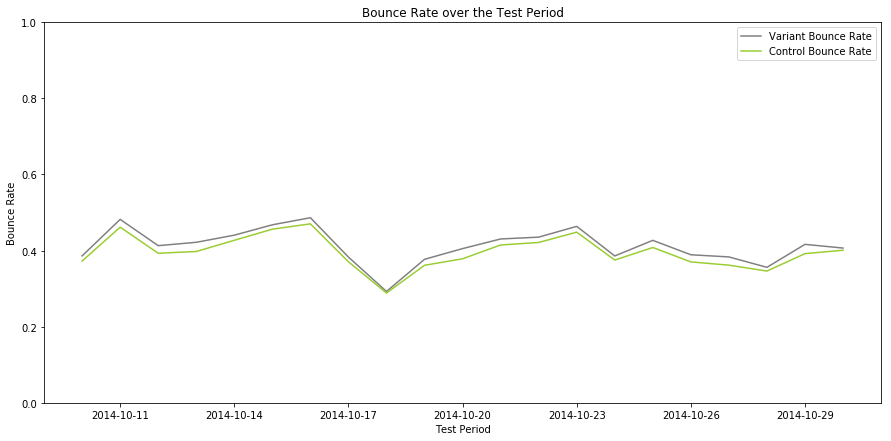

In [102]:
#Plot daily bounce rates over the test period.
plt.subplots(figsize=(15, 7))
plt.plot(variant_timeser.index, variant_timeser.values,'gray', label='Variant Bounce Rate')
plt.plot(control_timeser.index, control_timeser.values,'yellowgreen', label='Control Bounce Rate')
plt.ylim(0,1)
plt.title('Bounce Rate over the Test Period')
plt.ylabel('Bounce Rate')
plt.xlabel('Test Period')
plt.legend()

## Appendix C: Conversion Rates by User Type

In [103]:
#Build a function that calculates the conversion rate for the control and variant by user type over the test period

def conrate_by_usertype(sample_type, user_type):
    #Calculate the number of people in the sample group who made a purchase
    no_vispurchase=visitor_data[(visitor_data['Purchase']==1) & (visitor_data['User Type']==user_type)][sample_type].sum()
    #Calculate total visitors by user type 
    no_visitors=visitor_data.groupby("User Type").sum().loc[user_type,sample_type]
    con_rate=no_vispurchase/no_visitors
    return con_rate

new_control_con=conrate_by_usertype('Visitors_Control','New User')
new_variant_con=conrate_by_usertype('Visitors_Variant','New User')
returning_control_con=conrate_by_usertype('Visitors_Control','Returning User')
returning_variant_con=conrate_by_usertype('Visitors_Variant','Returning User')

#Note that a visitor may be making more than one purchase, however, we can't account for this in the conversion rate
#because the data doesn't provide unique IDs for visitors. As a result, we may have overestimated the con rate. 

conrate_usertype={"Control Conversion Rate (New User)":new_control_con,"Variant Conversion Rate (New User)":new_variant_con,\
                  "Control Conversion Rate (Returning User)":returning_control_con, "Variant Conversion Rate (Returning User)":\
                  returning_variant_con}
conrate_usertype

{'Control Conversion Rate (New User)': 0.052846662452221922,
 'Control Conversion Rate (Returning User)': 0.059574415693677794,
 'Variant Conversion Rate (New User)': 0.051190573961224901,
 'Variant Conversion Rate (Returning User)': 0.055837883982834506}

In [104]:
#Build a function calculating conversion rates for each day by user type
def dailycon_by_usertype(sample_type, user_type):
    time_series=visitor_data.groupby('Date')\
    .apply(lambda x: x[(x['Purchase']==1) & (x['User Type']==user_type)][sample_type].sum()\
    / x[x['User Type']==user_type][sample_type].sum())
    return time_series

new_cont_timeser=dailycon_by_usertype('Visitors_Control','New User')
return_cont_timeser=dailycon_by_usertype('Visitors_Control','Returning User')
new_var_timeser=dailycon_by_usertype('Visitors_Variant','New User')
return_var_timeser=dailycon_by_usertype('Visitors_Variant','Returning User')

for item in [new_cont_timeser, return_cont_timeser, new_var_timeser, return_var_timeser]:
    item.index=pd.to_datetime(item.index)


In [105]:
#Perform t-test to determine if the difference in conv rates by user type is statistically
#significant
test_newuser_con=stats.ttest_rel(new_cont_timeser,new_var_timeser)
test_retuser_con=stats.ttest_rel(return_cont_timeser,return_var_timeser)
[test_newuser_con, test_retuser_con]
#The p-value is quite small for both test - way below the .05 standard. We reject the null hypothesis that the  mean
#conversion rates across the control and variant are not significantly different. In other words, the variant
#performs worse than the control because of the proposed changes to the homepage and not due to chance(or randomness) 

[Ttest_relResult(statistic=3.7570771960363021, pvalue=0.0012407234425023369),
 Ttest_relResult(statistic=5.2537023561456868, pvalue=3.8466361078215491e-05)]

In [106]:
#Summarize data on conversion rate by user type
condata_bytype={'Control Conversion Rate':[new_control_con, returning_control_con],
                   'Variant Conversion Rate': [new_variant_con, returning_variant_con],
                   'Agg. Relative Difference (%)': [rel_diff(new_variant_con,new_control_con),rel_diff(returning_variant_con,returning_control_con)], 
                   'Statistical Significance (95% level)':[(test_newuser_con[1]<0.05),(test_retuser_con[1]<0.05)]}

convdata_bytype= pd.DataFrame(condata_bytype, index=['New User', 'Returning User']) 
convdata_bytype=convdata_bytype[['Control Conversion Rate','Variant Conversion Rate','Agg. Relative Difference (%)','Statistical Significance (95% level)']]
convdata_bytype.round(3)

,Control Conversion Rate,Variant Conversion Rate,Agg. Relative Difference (%),Statistical Significance (95% level)
New User,0.053,0.051,-3.134,True
Returning User,0.060,0.056,-6.272,True


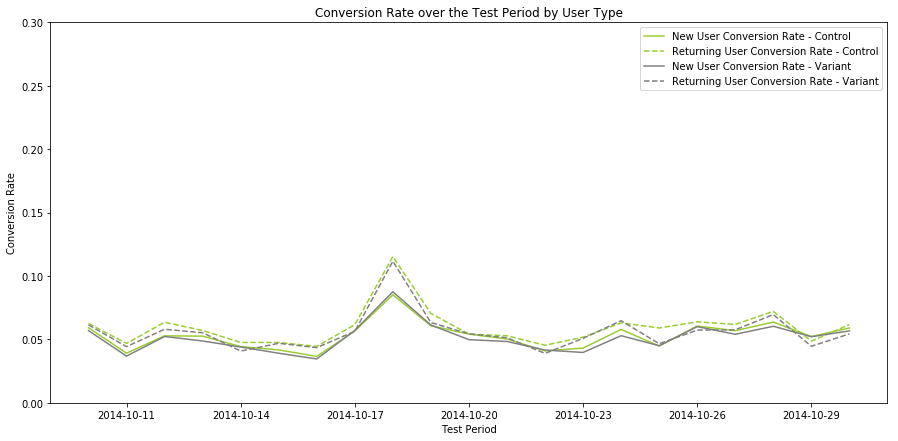

In [24]:
#Plot the control and variant conversion rate by user type over the test period.
plt.subplots(figsize=(15, 7))
plt.plot(new_cont_timeser.index, new_cont_timeser.values,linestyle='-',color='yellowgreen', label='New User Conversion Rate - Control')
plt.plot(return_cont_timeser.index, return_cont_timeser.values,linestyle='--',color='yellowgreen', label='Returning User Conversion Rate - Control')
plt.plot(new_var_timeser.index, new_var_timeser.values,linestyle='-',color='gray', label='New User Conversion Rate - Variant')
plt.plot(return_var_timeser.index, return_var_timeser.values,linestyle='--',color='gray', label='Returning User Conversion Rate - Variant')
plt.ylim(0,0.3)
plt.title('Conversion Rate over the Test Period by User Type')
plt.ylabel('Conversion Rate')
plt.xlabel('Test Period')
plt.legend()

## Appendix D: Bounce Rates by User Type

In [25]:
#Build a function that calculates the bounce rate for the control and variant by user type

def bonrate_by_usertype(sample_type,user_type):
    #Calculate the number of people in the sample group who made a purchase
    no_bounce=visitor_data[(visitor_data['Bounce']==1)& (visitor_data['User Type']==user_type)][sample_type].sum()
    #In calculating total number of visitors that land, we consider only the relevant user type
    no_landvis=visitor_data[(visitor_data['Land']==1) & (visitor_data['User Type']==user_type)][sample_type].sum()
    bon_rate=no_bounce/no_landvis
    return bon_rate

new_control_bon=bonrate_by_usertype('Visitors_Control','New User')
new_variant_bon=bonrate_by_usertype('Visitors_Variant','New User')
returning_control_bon=bonrate_by_usertype('Visitors_Control','Returning User')
returning_variant_bon=bonrate_by_usertype('Visitors_Variant','Returning User')


bonrate_usertype={"Control Bounce Rate (New User)":new_control_bon,"Variant Bounce Rate (New User)":new_variant_bon,\
                  "Control Bounce Rate (Returning User)":returning_control_bon, "Variant Bounce Rate (Returning User)":\
                  returning_variant_bon}
bonrate_usertype

{'Control Bounce Rate (New User)': 0.3990770595605268,
 'Control Bounce Rate (Returning User)': 0.3931053700316405,
 'Variant Bounce Rate (New User)': 0.41452631631860576,
 'Variant Bounce Rate (Returning User)': 0.409847178472803}

In [26]:
#Build a function calculating bounce rates for each day by user type
def dailybon_by_usertype(sample_type, user_type):
    time_series=visitor_data.groupby('Date')\
    .apply(lambda x: x[(x['Bounce']==1) & (x['User Type']==user_type)][sample_type].sum()\
    / x[(visitor_data['Land']==1) & (x['User Type']==user_type)][sample_type].sum())
    return time_series

newbon_cont_timeser=dailybon_by_usertype('Visitors_Control','New User')
returnbon_cont_timeser=dailybon_by_usertype('Visitors_Control','Returning User')
newbon_var_timeser=dailybon_by_usertype('Visitors_Variant','New User')
returnbon_var_timeser=dailybon_by_usertype('Visitors_Variant','Returning User')

for item in [newbon_cont_timeser, returnbon_cont_timeser, newbon_var_timeser, returnbon_var_timeser]:
    item.index=pd.to_datetime(item.index)

/Users/akselkohen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
#Perform t-test to determine if the difference in bounce rates by user type is statistically
#significant
test_newuser_bon=stats.ttest_rel(newbon_cont_timeser,newbon_var_timeser)
test_retuser_bon=stats.ttest_rel(returnbon_cont_timeser,returnbon_var_timeser)
[test_newuser_bon, test_retuser_bon]
#The p-value is quite small for both test - below the .05 standard. We reject the null hypothesis that the  mean
#conversion rates across the control and variant are not significantly different. In other words, the variant
#performs worse than the control because of the proposed changes to the homepage and not due to chance(or randomness) 

[Ttest_relResult(statistic=-2.7958332751159252, pvalue=0.011159403832035081),
 Ttest_relResult(statistic=-2.5208602779884766, pvalue=0.020307249131212079)]

In [28]:
#Summarize the data on bounce rate by user type
bouncedata_bytype={'Control Bounce Rate':[new_control_bon, returning_control_bon],
                   'Variant Bounce Rate': [new_variant_bon, returning_variant_bon],
                   'Agg. Relative Difference (%)': [rel_diff(new_variant_bon,new_control_bon),rel_diff(returning_variant_bon,returning_control_bon)], 
                   'Statistical Significance (95% level)':[(test_newuser_bon[1]<0.05),(test_retuser_bon[1]<0.05)]}

bouncedata_bytype= pd.DataFrame(bouncedata_bytype, index=['New User', 'Returning User']) 
bouncedata_bytype=bouncedata_bytype[['Control Bounce Rate','Variant Bounce Rate','Agg. Relative Difference (%)','Statistical Significance (95% level)']]
bouncedata_bytype.round(3)


,Control Bounce Rate,Variant Bounce Rate,Agg. Relative Difference (%),Statistical Significance (95% level)
New User,0.399,0.415,3.871,True
Returning User,0.393,0.410,4.259,True


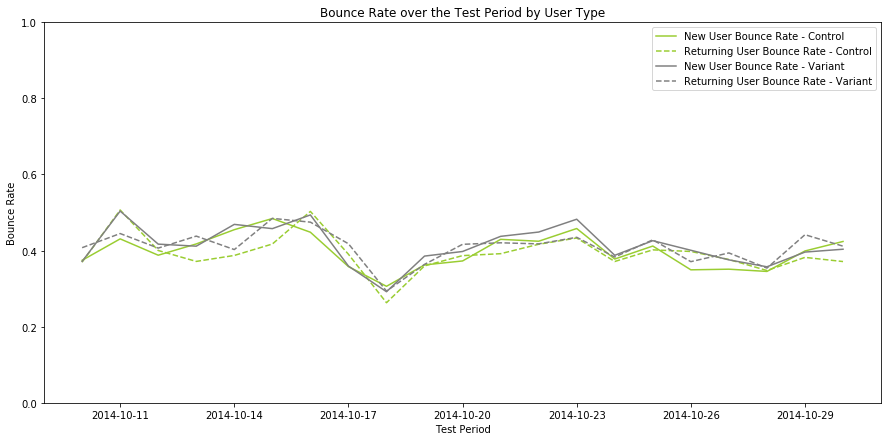

In [29]:
#Plot the control and variant bounce rate by user type over the test period.
plt.subplots(figsize=(15, 7))
plt.plot(newbon_cont_timeser.index, newbon_cont_timeser.values,linestyle='-',color='yellowgreen', label='New User Bounce Rate - Control')
plt.plot(returnbon_cont_timeser.index, returnbon_cont_timeser.values,linestyle='--',color='yellowgreen', label='Returning User Bounce Rate - Control')
plt.plot(newbon_var_timeser.index, newbon_var_timeser.values,linestyle='-',color='gray', label='New User Bounce Rate - Variant')
plt.plot(returnbon_var_timeser.index, returnbon_var_timeser.values,linestyle='--',color='gray', label='Returning User Bounce Rate - Variant')
plt.ylim(0,1)
plt.title('Bounce Rate over the Test Period by User Type')
plt.ylabel('Bounce Rate')
plt.xlabel('Test Period')
plt.legend()

## Appendix E: Conversion Rates by User Type and Channel 

In [30]:
#Build a function that calculates the conversion rate for the control and variant by user type and channel


def conrate_by_userchannel(sample_type, channel, user_type):
    #Calculate the number of people in the sample group who made a purchase
    no_vispurchase=visitor_data[(visitor_data['Purchase']==1) & (visitor_data['User Type']==user_type) & (visitor_data['Channel']==channel)][sample_type].sum()
    #Calculate total visitors by user type and channel 
    no_visitors=visitor_data.groupby(["User Type","Channel"]).sum().loc[user_type].loc[channel,sample_type]
    con_rate=no_vispurchase/no_visitors
    return con_rate



df=visitor_data.groupby(["User Type","Channel"]).sum().drop(['Land','Bounce','Purchase'],axis=1)
df['Visitors_Control']=np.zeros(df.shape[0])
df['Visitors_Variant']=np.zeros(df.shape[0])
df['Agg. Relative Difference (%)']=np.zeros(df.shape[0])


for sample in ['Visitors_Control','Visitors_Variant']:
    for channel in ['Affiliate','Direct','Email','Paid Search','SEO','Social Media']:
        for user in ['New User', 'Returning User']:
            con_rate=conrate_by_userchannel(sample, channel, user)
            df.loc[user].loc[channel,sample]=con_rate  
df.rename(columns = {'Visitors_Control':'Control Conversion Rate', 'Visitors_Variant':'Variant Conversion Rate'}, inplace = True) 
df['Agg. Relative Difference (%)']= (df['Variant Conversion Rate'] - df['Control Conversion Rate'])/df['Control Conversion Rate']*100     
df.round(3)
df

Control Conversion Rate  Variant Conversion Rate  \
User Type      Channel                                                          
New User       Affiliate                    0.052772                 0.053919   
               Direct                       0.053452                 0.050366   
               Email                        0.053099                 0.050100   
               Paid Search                  0.051918                 0.052181   
               SEO                          0.051855                 0.049708   
               Social Media                 0.054804                 0.054818   
Returning User Affiliate                    0.059545                 0.056518   
               Direct                       0.057411                 0.053540   
               Email                        0.067305                 0.063014   
               Paid Search                  0.064533                 0.057552   
               SEO                          0.055572                 0.052076   
               Social Media                 0.074787                 0.075372   

                             Agg. Relative Difference (%)  
User Type      Channel                                     
New User       Affiliate                         2.172776  
               Direct                           -5.773703  
               Email                            -5.647186  
               Paid Search                       0.506538  
               SEO                              -4.139490  
               Social Media                      0.026526  
Returning User Affiliate                        -5.083931  
               Direct                           -6.742586  
               Email                            -6.375817  
               Paid Search                     -10.816519  
               SEO                              -6.290634  
               Social Media                      0.782312

In [31]:
#Build a function calculating the conversation rate for each day by user type and channel. Use this data to test for
#statistical significance

def dailycon_by_usertypechannel(sample_type, channel,user_type):
    time_series=visitor_data.groupby('Date')\
    .apply(lambda x: x[(x['Purchase']==1) & (x['User Type']==user_type) & (visitor_data['Channel']==channel)][sample_type].sum()\
    / x[(x['User Type']==user_type)&(visitor_data['Channel']==channel)][sample_type].sum())
    return time_series

df['Statistical Significance (95% level)']=""

for channel in ['Affiliate','Direct','Email','Paid Search','SEO','Social Media']:
    for user in ['New User', 'Returning User']:
        control=dailycon_by_usertypechannel('Visitors_Control', channel,user)
        variant=dailycon_by_usertypechannel('Visitors_Variant', channel,user)
        test=stats.ttest_rel(control,variant)
        df.loc[user].loc[channel,"Statistical Significance (95% level)"]= (test[1] <0.05)

df.round(3)

        


            


/Users/akselkohen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/akselkohen/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Control Conversion Rate  Variant Conversion Rate  \
User Type      Channel                                                          
New User       Affiliate                       0.053                    0.054   
               Direct                          0.053                    0.050   
               Email                           0.053                    0.050   
               Paid Search                     0.052                    0.052   
               SEO                             0.052                    0.050   
               Social Media                    0.055                    0.055   
Returning User Affiliate                       0.060                    0.057   
               Direct                          0.057                    0.054   
               Email                           0.067                    0.063   
               Paid Search                     0.065                    0.058   
               SEO                             0.056                    0.052   
               Social Media                    0.075                    0.075   

                             Agg. Relative Difference (%)  \
User Type      Channel                                      
New User       Affiliate                            2.173   
               Direct                              -5.774   
               Email                               -5.647   
               Paid Search                          0.507   
               SEO                                 -4.139   
               Social Media                         0.027   
Returning User Affiliate                           -5.084   
               Direct                              -6.743   
               Email                               -6.376   
               Paid Search                        -10.817   
               SEO                                 -6.291   
               Social Media                         0.782   

                            Statistical Significance (95% level)  
User Type      Channel                                            
New User       Affiliate                                   False  
               Direct                                       True  
               Email                                        True  
               Paid Search                                 False  
               SEO                                         False  
               Social Media                                False  
Returning User Affiliate                                   False  
               Direct                                       True  
               Email                                       False  
               Paid Search                                  True  
               SEO                                         False  
               Social Media                                False